In [1]:
from epymorph.adrio import acs5
from epymorph import *  # noqa: F403
from epymorph.geography.us_census import StateScope
from epymorph.data.ipm.sirh import SIRH
from epymorph.data.mm.no import No
from epymorph.initializer import Proportional
from epymorph.rume import SingleStrataRUME
from epymorph.time import TimeFrame
import numpy as np
import matplotlib.pyplot as plt

from epymorph.attribute import NamePattern


duration = 7 * 14
t = np.arange(0, duration)
true_beta = 0.03 * np.cos(t * 2 * np.pi / (365)) + 0.28

rume = SingleStrataRUME.build(
    ipm=SIRH(),
    mm=No(),
    scope=StateScope.in_states(["AZ"], year=2015),
    init=Proportional(ratios=np.array([9999, 1, 0, 0], dtype=np.int64)),
    time_frame=TimeFrame.of("2022-10-01", 7 * 14),
    params={
        "beta": true_beta,
        "gamma": 0.25,
        "xi": 1 / 365,  # 0.0111,
        "hospitalization_prob": 0.01,
        "hospitalization_duration": 5.0,
        "population": acs5.Population(),
    },
)

In [2]:
rume.time_frame.end_date

datetime.date(2023, 1, 6)

In [3]:
from pathlib import Path
from epymorph.adrio import acs5, csv

csvadrio = csv.CSVTimeSeries(
    file_path=Path("./doc/devlog/data/14week_temp_synthetic_data.csv"),
    time_col=0,
    time_frame=rume.time_frame,
    key_col=1,
    data_col=2,
    data_type=int,
    key_type="geoid",
    skiprows=1,
)

In [4]:
from epymorph.parameter_fitting.filter.particle_filter import ParticleFilter
from epymorph.parameter_fitting.likelihood import Poisson
from epymorph.parameter_fitting.utils.observations import ModelLink, Observations

from epymorph.time import EveryNDays

quantity_selection = rume.ipm.select.events("I->H")
time_selection = rume.time_frame.select.all().group(EveryNDays(7)).agg()
geo_selection = rume.scope.select.all()

observations = Observations(
    source=csvadrio,
    model_link=ModelLink(
        quantity=quantity_selection,
        time=time_selection,
        geo=geo_selection,
    ),
    likelihood=Poisson(),
)

filter_type = ParticleFilter(num_particles=500)

In [5]:
from epymorph.parameter_fitting.distribution import Uniform
from epymorph.parameter_fitting.dynamics import GeometricBrownianMotion
from epymorph.parameter_fitting.perturbation import Calvetti
from epymorph.parameter_fitting.utils.parameter_estimation import (
    EstimateParameters,
    ForecastParameters,
)

params_space = {
    "beta": EstimateParameters.TimeVarying(
        distribution=Uniform(a=0.05, b=0.5),
        dynamics=GeometricBrownianMotion(volatility=0.04),
    ),
    "xi": EstimateParameters.Static(
        distribution=Uniform(a=0.001, b=0.01),
        perturbation=Calvetti(a=0.9),
    ),
}

In [6]:
from epymorph.parameter_fitting.particlefilter_simulation import FilterSimulation

sim = FilterSimulation(
    rume=rume,
    observations=observations,
    filter_type=filter_type,
    params_space=params_space,
)

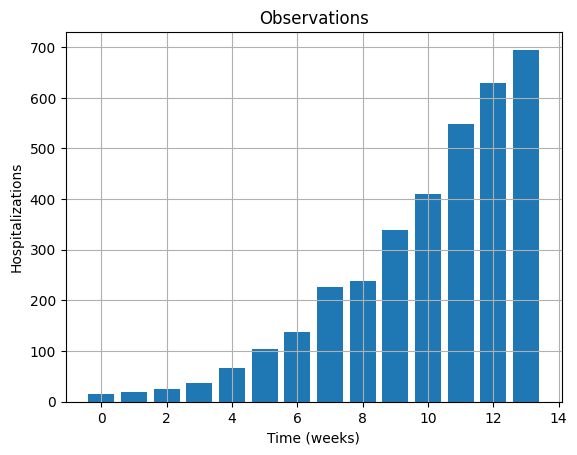

In [7]:
plt.bar(range(len(sim.cases)), sim.cases[:, 0])
plt.title("Observations")
plt.xlabel("Time (weeks)")
plt.ylabel("Hospitalizations")
plt.grid(True)
plt.show()

In [8]:
rng = np.random.default_rng(seed=1)
output = sim.run(rng=rng)

Running Particle Filter simulation
• 2022-10-01 00:00:00 to 2022-12-31 00:00:00 (98 days)
• 500 particles

Simulation completed in 321.49s

Parameters estimated: ['beta', 'xi']


In [9]:
output.model_data

array([[  1],
       [ 17],
       [ 79],
       [ 52],
       [ 65],
       [104],
       [167],
       [199],
       [350],
       [320],
       [463],
       [525],
       [769],
       [724]])

In [ ]:
params_space = {
    "beta": ForecastParameters.TimeVarying(
        dynamics=GeometricBrownianMotion(volatility=0.04),
    )
}

In [ ]:
quantity_selection = rume.ipm.select.events("S->I")
time_selection = rume.time_frame.select.all().group(EveryNDays(7)).agg()
geo_selection = rume.scope.select.all()

get_model_link = ModelLink(
    quantity=quantity_selection,
    time=time_selection,
    geo=geo_selection,
)

In [ ]:
from epymorph.parameter_forecasting.forecast_class import ForecastSimulation


sim = ForecastSimulation(
    initial_particles=output.particles,
    # num_particles=500,
    rume=rume,
    params_space=params_space,
    model_link=observations.model_link,
    duration=40,
    request_data={
        "quantity": get_model_link,
        # "particle_cloud": ["2023-01-20", "2023-02-10"],
    },
)

In [12]:
forecast_output = sim.run()

In [13]:
# forecast_output.model_data

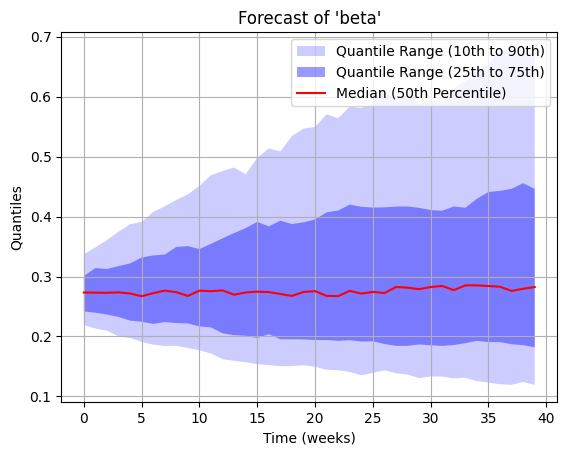

In [14]:
import matplotlib.pyplot as plt


key = "beta"
node_index = 0
truth = None

key_quantiles = np.array(forecast_output.param_quantiles[key])

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 3, 0],
    key_quantiles[:, 22 - 3, 0],
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th)",
)

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 6, 0],
    key_quantiles[:, 22 - 6, 0],
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th)",
)

plt.plot(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 11, 0],
    color="red",
    label="Median (50th Percentile)",
)


plt.title(f"Forecast of '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

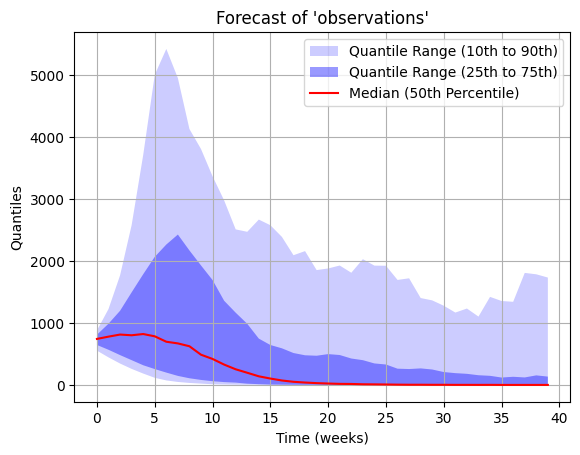

In [15]:
import matplotlib.pyplot as plt


key = "observations"
node_index = 0
truth = None

key_quantiles = np.array(forecast_output.model_data_quantiles)

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 3, 0],
    key_quantiles[:, 22 - 3, 0],
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th)",
)
plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 6, 0],
    key_quantiles[:, 22 - 6, 0],
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th)",
)

plt.plot(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 11, 0],
    color="red",
    label="Median (50th Percentile)",
)

plt.title(f"Forecast of '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

In [16]:
len(output.param_quantiles["beta"])

14

In [17]:
len(forecast_output.param_quantiles["beta"])

40

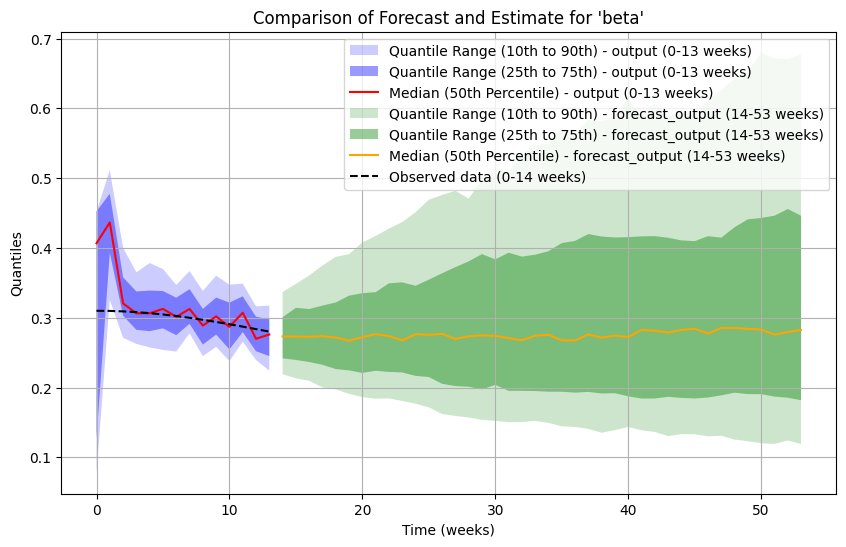

In [18]:
# Assuming output and forecast_output are already loaded as per your data.
key = "beta"
node_index = 0
truth = None

# First 14 weeks (from output)
key_quantiles_1 = np.array(output.param_quantiles[key])  # Data for weeks 0 to 13

# Next 40 weeks (from forecast_output)
key_quantiles_2 = np.array(
    forecast_output.param_quantiles[key]
)  # Data for weeks 14 to 53

# Create a plot for both datasets, for a total of 54 weeks (0-53)
plt.figure(figsize=(10, 6))

# Plot first dataset (output) for the first 14 weeks (0 to 13)
plt.fill_between(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 3, 0],  # 10th Percentile
    key_quantiles_1[:, 22 - 3, 0],  # 90th Percentile
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th) - output (0-13 weeks)",
)

plt.fill_between(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 6, 0],  # 25th Percentile
    key_quantiles_1[:, 22 - 6, 0],  # 75th Percentile
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th) - output (0-13 weeks)",
)

plt.plot(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 11, 0],  # Median (50th Percentile)
    color="red",
    label="Median (50th Percentile) - output (0-13 weeks)",
)

# Plot second dataset (forecast_output) for the next 40 weeks (14 to 53)
plt.fill_between(
    np.arange(14, 54),  # Weeks 14-53
    key_quantiles_2[:, 3, 0],  # 10th Percentile
    key_quantiles_2[:, 22 - 3, 0],  # 90th Percentile
    facecolor="green",
    alpha=0.2,
    label="Quantile Range (10th to 90th) - forecast_output (14-53 weeks)",
)

plt.fill_between(
    np.arange(14, 54),  # Weeks 14-53
    key_quantiles_2[:, 6, 0],  # 25th Percentile
    key_quantiles_2[:, 22 - 6, 0],  # 75th Percentile
    facecolor="green",
    alpha=0.4,
    label="Quantile Range (25th to 75th) - forecast_output (14-53 weeks)",
)

plt.plot(
    np.arange(14, 54),  # Weeks 14-53
    key_quantiles_2[:, 11, 0],  # Median (50th Percentile)
    color="orange",
    label="Median (50th Percentile) - forecast_output (14-53 weeks)",
)

# Combine both data sets' observed data if available
obs_0_13 = np.arange(0, 14)
plt.plot(
    obs_0_13,
    np.array(rume.params[NamePattern(strata="*", module="*", id="beta")])[::7],
    "k--",
    label="Observed data (0-14 weeks)",
)

# Title, labels, and legend
plt.title(f"Comparison of Forecast and Estimate for '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)

# Show the combined plot
plt.show()


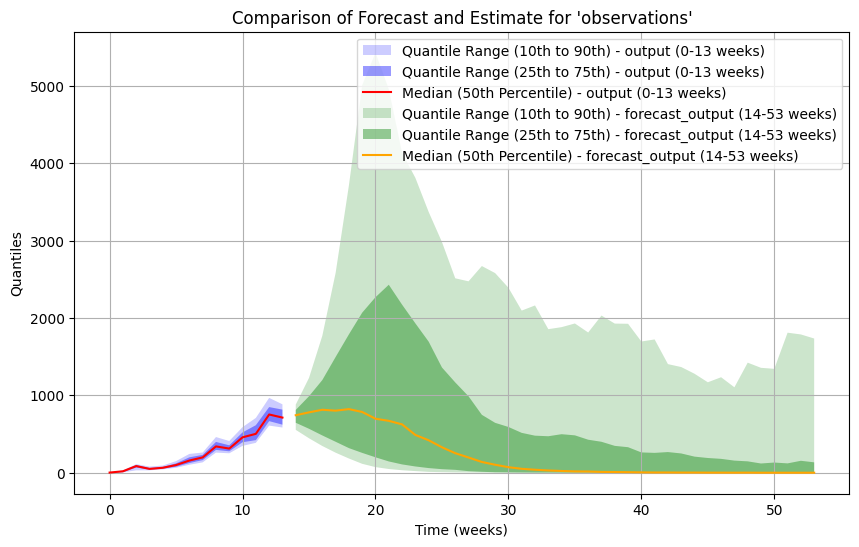

In [19]:
import matplotlib.pyplot as plt
import numpy as np

key = "observations"
node_index = 0
truth = None

# Get the quantiles for the two datasets
key_quantiles_1 = np.array(output.model_data_quantiles)  # Weeks 0 to 13 (output)
key_quantiles_2 = np.array(
    forecast_output.model_data_quantiles
)  # Weeks 14 to 53 (forecast_output)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot first dataset (output) for the first 14 weeks (0 to 13)
plt.fill_between(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 3, 0],  # 10th Percentile
    key_quantiles_1[:, 22 - 3, 0],  # 90th Percentile
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th) - output (0-13 weeks)",
)

plt.fill_between(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 6, 0],  # 25th Percentile
    key_quantiles_1[:, 22 - 6, 0],  # 75th Percentile
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th) - output (0-13 weeks)",
)

plt.plot(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 11, 0],  # Median (50th Percentile)
    color="red",
    label="Median (50th Percentile) - output (0-13 weeks)",
)

# Plot second dataset (forecast_output) for the next 40 weeks (14 to 53)
plt.fill_between(
    np.arange(14, 54),  # Weeks 14-53
    key_quantiles_2[:, 3, 0],  # 10th Percentile
    key_quantiles_2[:, 22 - 3, 0],  # 90th Percentile
    facecolor="green",
    alpha=0.2,
    label="Quantile Range (10th to 90th) - forecast_output (14-53 weeks)",
)

plt.fill_between(
    np.arange(14, 54),  # Weeks 14-53
    key_quantiles_2[:, 6, 0],  # 25th Percentile
    key_quantiles_2[:, 22 - 6, 0],  # 75th Percentile
    facecolor="green",
    alpha=0.4,
    label="Quantile Range (25th to 75th) - forecast_output (14-53 weeks)",
)

plt.plot(
    np.arange(14, 54),  # Weeks 14-53
    key_quantiles_2[:, 11, 0],  # Median (50th Percentile)
    color="orange",
    label="Median (50th Percentile) - forecast_output (14-53 weeks)",
)

# Title, labels, and legend
plt.title(f"Comparison of Forecast and Estimate for '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)

# Show the combined plot
plt.show()


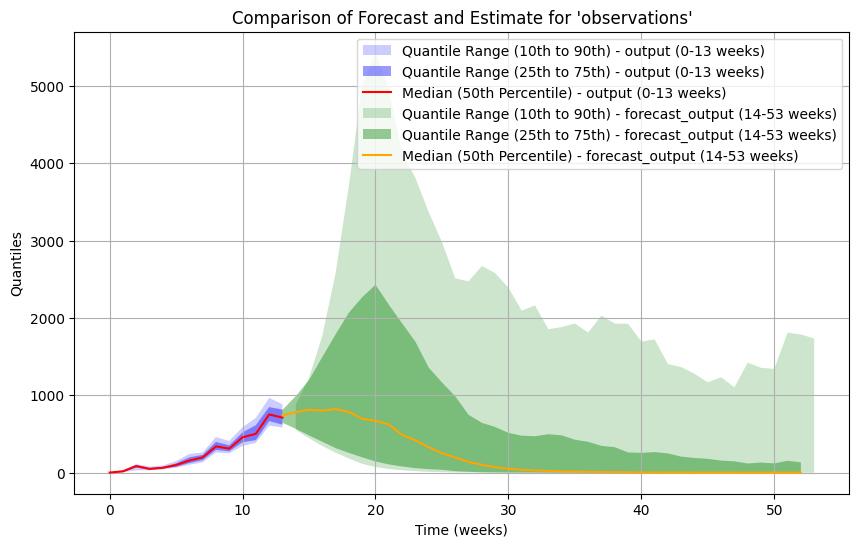

In [20]:
import matplotlib.pyplot as plt
import numpy as np

key = "observations"
node_index = 0
truth = None

# Get the quantiles for the two datasets
key_quantiles_1 = np.array(output.model_data_quantiles)  # Weeks 0 to 13 (output)
key_quantiles_2 = np.array(
    forecast_output.model_data_quantiles
)  # Weeks 14 to 53 (forecast_output)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot first dataset (output) for the first 14 weeks (0 to 13)
plt.fill_between(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 3, 0],  # 10th Percentile
    key_quantiles_1[:, 22 - 3, 0],  # 90th Percentile
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th) - output (0-13 weeks)",
)

plt.fill_between(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 6, 0],  # 25th Percentile
    key_quantiles_1[:, 22 - 6, 0],  # 75th Percentile
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th) - output (0-13 weeks)",
)

plt.plot(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 11, 0],  # Median (50th Percentile)
    color="red",
    label="Median (50th Percentile) - output (0-13 weeks)",
)

# Plot second dataset (forecast_output) for the next 40 weeks (14 to 53)
plt.fill_between(
    np.arange(14, 54),  # Weeks 14-53
    key_quantiles_2[:, 3, 0],  # 10th Percentile
    key_quantiles_2[:, 22 - 3, 0],  # 90th Percentile
    facecolor="green",
    alpha=0.2,
    label="Quantile Range (10th to 90th) - forecast_output (14-53 weeks)",
)

plt.fill_between(
    np.arange(13, 53),  # Weeks 14-53
    key_quantiles_2[:, 6, 0],  # 25th Percentile
    key_quantiles_2[:, 22 - 6, 0],  # 75th Percentile
    facecolor="green",
    alpha=0.4,
    label="Quantile Range (25th to 75th) - forecast_output (14-53 weeks)",
)

plt.plot(
    np.arange(13, 53),  # Weeks 14-53
    key_quantiles_2[:, 11, 0],  # Median (50th Percentile)
    color="orange",
    label="Median (50th Percentile) - forecast_output (14-53 weeks)",
)

# Title, labels, and legend
plt.title(f"Comparison of Forecast and Estimate for '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)

# Show the combined plot
plt.show()


# Running the particle filter without running the particle filter

In [6]:
from epymorph.adrio import acs5
from epymorph import *  # noqa: F403
from epymorph.geography.us_census import StateScope
from epymorph.data.ipm.sirh import SIRH
from epymorph.data.mm.no import No
from epymorph.initializer import Proportional
from epymorph.rume import SingleStrataRUME
from epymorph.time import TimeFrame
import numpy as np

duration = 7 * 40
t = np.arange(0, duration)
true_beta = 0.03 * np.cos(t * 2 * np.pi / (365)) + 0.28

rume = SingleStrataRUME.build(
    ipm=SIRH(),
    mm=No(),
    scope=StateScope.in_states(["AZ"], year=2015),
    init=Proportional(ratios=np.array([9999, 1, 0, 0], dtype=np.int64)),
    time_frame=TimeFrame.of("2022-10-01", duration),
    params={
        "beta": true_beta,
        "gamma": 0.25,
        "xi": 1 / 365,  # 0.0111,
        "hospitalization_prob": 0.01,
        "hospitalization_duration": 5.0,
        "population": acs5.Population(),
    },
)

In [7]:
rume.time_frame.start_date

datetime.date(2022, 10, 1)

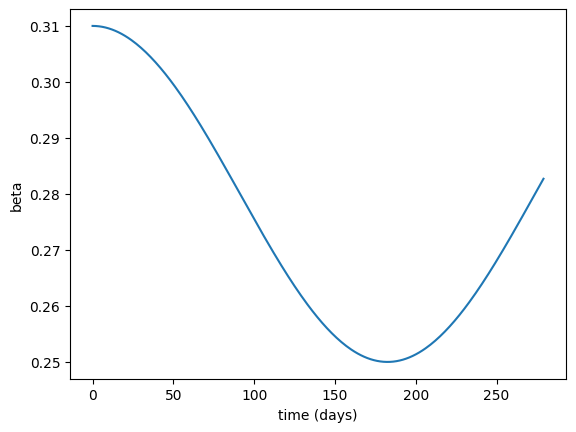

In [8]:
import matplotlib.pyplot as plt

plt.plot(t, true_beta)
plt.ylabel("beta")
plt.xlabel("time (days)")
# plt.ylim(0, 0.4)
plt.show()

In [9]:
from epymorph.parameter_fitting.utils.observations import ModelLink

from epymorph.time import EveryNDays

quantity_selection = rume.ipm.select.events("I->H")
time_selection = rume.time_frame.select.all().group(EveryNDays(7)).agg()
geo_selection = rume.scope.select.all()


model_link = ModelLink(
    quantity=quantity_selection,
    time=time_selection,
    geo=geo_selection,
)

In [10]:
from epymorph.parameter_fitting.utils.parameter_estimation import EstimateParameters
from epymorph.parameter_forecasting.forecast_class import ForecastSimulation
from epymorph.parameter_fitting.distribution import Uniform
from epymorph.parameter_fitting.dynamics import GeometricBrownianMotion
from epymorph.parameter_fitting.perturbation import Calvetti

params_space = {
    "beta": EstimateParameters.TimeVarying(
        distribution=Uniform(a=0.05, b=0.5),
        dynamics=GeometricBrownianMotion(volatility=0.04),
    ),
    "xi": EstimateParameters.Static(
        distribution=Uniform(a=0.001, b=0.01),
        perturbation=Calvetti(a=0.9),
    ),
}


sim = ForecastSimulation(
    # initial_particles=output.particles,
    num_particles=500,
    rume=rume,
    params_space=params_space,
    model_link=model_link,
    duration=53,
)

APIKeyError: ' <html style="font-size: 14px;">     <head>         <title>Invalid Key</title>         <link rel="icon" type="image/x-icon" href="favicon.ico">         <link rel="stylesheet" type="text/css" href="assets/styles.css">         <script type="text/javascript" src="assets/jquery-1.4.4.min.js"></script>         <script type="text/javascript">             $(document).ready(function() {                 $(".menu-activator").click(function() {                     $(".gov-menu").toggle()                     $(".chevron").toggleClass(\'rotate\')                 })                             })         </script>     </head>     <body>         <header>             <div data-v-8adc6fed="" data-v-2f72e816="" class="gov-banner noprint">                 <div data-v-8adc6fed="" class="aqua-layout horizontal align-start justify-start banner-header">                     <img data-v-8adc6fed="" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAABAAAAALCAMAAABBPP0LAAAAG1BMVEUdM7EeNLIeM7HgQCDaPh/bPh/bPx/////bPyBEby41AAAAUElEQVQI123MNw4CABDEwD3jC/9/MQ1BQrgeOSkIqYe2o2FZtthXgQLgbHVMZdlsfUQFQnHtjP1+8BUhBDKOqtmfot6ojqPzR7TjdU+f6vkED+IDPhTBcMAAAAAASUVORK5CYII=" alt="U.S flag" class="usflag" role="img" aria-hidden="true">                     <span data-v-8adc6fed="">                         <div data-v-8adc6fed="" class="aqua-layout horizontal" tabindex="0">                             <div data-v-8adc6fed="" tabindex="0" aria-label="An official website of the United States government">                                  An official website of the United States government                              </div>                             <div data-v-8adc6fed="" class="menu-activator" aria-label="Here\'s how you know. Press enter for more information." tabindex="0">                                 <div data-v-8adc6fed="" class="aqua-layout horizontal justify-start"> Here&rsquo;s how you know <div data-v-8adc6fed="" class="chevron"><img  data-v-8adc6fed="" class="aqua-icon" src="assets/images/chevron-down.svg" style="width: 0.75rem; height: 0.75rem; max-height: 0.75rem; transition: all 500ms ease 0s; filter: invert(30%) sepia(8%) saturate(3837%) hue-rotate(171deg) brightness(99%) contrast(89%);"></div>                                 </div>                             </div>                         </div>                     </span>                 </div>                 <div data-v-8adc6fed="" class="aqua-layout horizontal justify-start gov-menu" style="display: none;"><div data-v-8adc6fed="" class="aqua-layout horizontal justify-start menu-paragraph"><img data-v-8adc6fed="" class="menu-svg" src="assets/images/icon-gov-building.svg" role="img" alt="government building image" aria-hidden="true"><div data-v-8adc6fed="" tabindex="0" aria-label="Official websites use .gov. A .gov website belongs to an official government                 organization in the United States."><strong data-v-8adc6fed=""> Official websites use .gov </strong>                 <br data-v-8adc6fed=""> A <strong data-v-8adc6fed="">.gov</strong> website belongs to an official government organization in the United States. </div>             </div>             <div data-v-8adc6fed="" class="aqua-layout horizontal justify-start menu-paragraph"><img data-v-8adc6fed="" class="menu-svg" src="assets/images/icon-lock.svg" role="img" alt="lock image" aria-hidden="true">                 <div data-v-8adc6fed="" tabindex="0" aria-label="Secure .gov websites use HTTPS. A lock or https:// means youâ\x80\x99ve safely connected to the                 .gov website. Share sensitive information only on official, secure                 websites."><strong data-v-8adc6fed=""> Secure .gov websites use HTTPS </strong>                 <br data-v-8adc6fed=""> A <strong data-v-8adc6fed="">lock</strong> ( <img data-v-8adc6fed="" class="menu-lock" src="assets/images/lock.svg" role="img" alt="lock image" aria-hidden="true"> ) or <strong data-v-8adc6fed="">https://</strong> means you&lsquo;ve safely connected to the .gov website. Share sensitive information only on official, secure websites. </div>             </div>         </div>     </div>     <div data-v-beed8774="" data-v-2f72e816="" role="banner" class="AppHeader noprint" aqua-relative="">         <div data-v-beed8774="" class="aqua-layout horizontal align-center justify-center"><!---->             <div data-v-beed8774="" class="aqua-flex" style="flex: 0 0 auto;">                 <div data-v-beed8774="" class="aqua-layout vertical">                     <div data-v-beed8774="" class="logoArea">                         <a data-v-fb9b02c5="" data-v-beed8774="" href="/" class="" id="census-home-link">                             <div data-v-fb9b02c5="" style="display: none;"></div>                             <img data-v-beed8774="" class="header-logo" src="assets/images/census-logo-gray.svg" alt="United States Census Bureau - Census Data Homepage">                         </a>                     </div>                 </div>             </div><!----><!---->             <div data-v-beed8774="" class="aqua-layout vertical"></div>         </div>     </div> </div> </header> <div class="flex-container content">     <div class="content-wrap center">         <h1>Invalid Key</h1>         <p>             A valid <em>key</em> must be included with each data API request.             You included a key with this request, however, it is not valid.             Please check your key and try again.         </p>         <p>             If you do not have a key you may sign up for one <a href="key_signup.html">here</a>.         </p>     </div>       </div>  <div data-v-56f1d3f7="" class="aqua-flex" style="flex: 0 0 auto;">     <footer data-v-db923c0a="" data-v-56f1d3f7="" class="PageFooter">         <div data-v-db923c0a="" class="aqua-layout align-center justify-center links aqua-text-caption">             <a data-v-db923c0a="" target="_blank" href="https://www.census.gov/about/policies/section-508.html">Accessibility</a>             <span data-v-db923c0a="" aria-hidden="true">&nbsp;|&nbsp;</span>             <a data-v-db923c0a="" target="_blank" href="https://www.census.gov/quality/">Information Quality</a>             <span data-v-db923c0a="" aria-hidden="true">&nbsp;|&nbsp;</span>             <a data-v-db923c0a="" target="_blank" href="https://www.census.gov/foia/">FOIA</a>             <span data-v-db923c0a="" aria-hidden="true">&nbsp;|&nbsp;</span>             <a data-v-db923c0a="" target="_blank" href="https://www.census.gov/privacy/">Data Protection and Privacy Policy</a>             <span data-v-db923c0a="" aria-hidden="true">&nbsp;|&nbsp;</span>             <a data-v-db923c0a="" target="_blank" href="https://www.commerce.gov/">U.S. Department of Commerce</a>             <span data-v-db923c0a="" aria-hidden="true">&nbsp;|&nbsp;</span>             <a data-v-db923c0a="" target="_blank" href="https://www2.census.gov/data/api-documentation/data-census-gov-release-notes.pdf?#">Release Notes</a>         </div>     </footer> </div>       </body> </html>'

In [23]:
forecast_output_2 = sim.run()

ValueError: When applying a geo selection, please create that selection from the same scope you are applying it to.

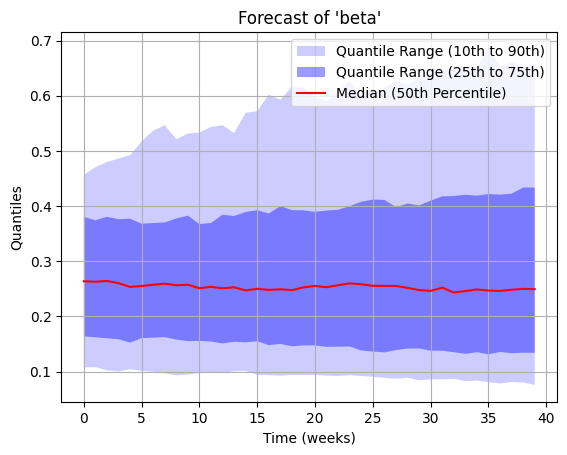

In [ ]:
import matplotlib.pyplot as plt


key = "beta"
node_index = 0
truth = None

key_quantiles = np.array(forecast_output_2.param_quantiles[key])

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 3, 0],
    key_quantiles[:, 22 - 3, 0],
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th)",
)

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 6, 0],
    key_quantiles[:, 22 - 6, 0],
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th)",
)

plt.plot(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 11, 0],
    color="red",
    label="Median (50th Percentile)",
)


plt.title(f"Forecast of '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

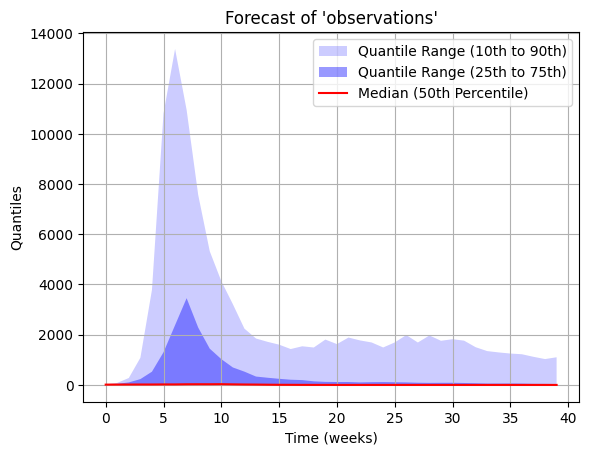

In [ ]:
import matplotlib.pyplot as plt


key = "observations"
node_index = 0
truth = None

key_quantiles = np.array(forecast_output_2.model_data_quantiles)

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 3, 0],
    key_quantiles[:, 22 - 3, 0],
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th)",
)
plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 6, 0],
    key_quantiles[:, 22 - 6, 0],
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th)",
)

plt.plot(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 11, 0],
    color="red",
    label="Median (50th Percentile)",
)

plt.title(f"Forecast of '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

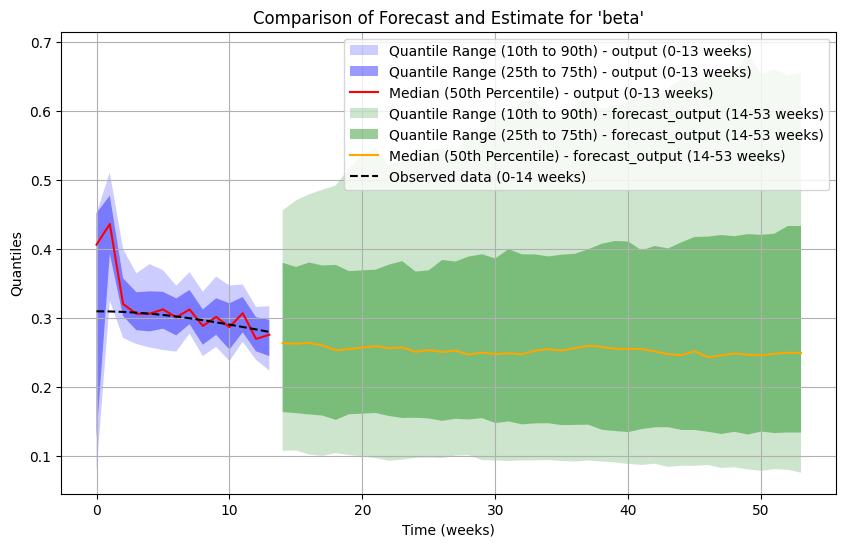

In [ ]:
# Assuming output and forecast_output are already loaded as per your data.
key = "beta"
node_index = 0
truth = None

# First 14 weeks (from output)
key_quantiles_1 = np.array(output.param_quantiles[key])  # Data for weeks 0 to 13

# Next 40 weeks (from forecast_output)
key_quantiles_2 = np.array(
    forecast_output_2.param_quantiles[key]
)  # Data for weeks 14 to 53

# Create a plot for both datasets, for a total of 54 weeks (0-53)
plt.figure(figsize=(10, 6))

# Plot first dataset (output) for the first 14 weeks (0 to 13)
plt.fill_between(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 3, 0],  # 10th Percentile
    key_quantiles_1[:, 22 - 3, 0],  # 90th Percentile
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th) - output (0-13 weeks)",
)

plt.fill_between(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 6, 0],  # 25th Percentile
    key_quantiles_1[:, 22 - 6, 0],  # 75th Percentile
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th) - output (0-13 weeks)",
)

plt.plot(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 11, 0],  # Median (50th Percentile)
    color="red",
    label="Median (50th Percentile) - output (0-13 weeks)",
)

# Plot second dataset (forecast_output) for the next 40 weeks (14 to 53)
plt.fill_between(
    np.arange(14, 54),  # Weeks 14-53
    key_quantiles_2[:, 3, 0],  # 10th Percentile
    key_quantiles_2[:, 22 - 3, 0],  # 90th Percentile
    facecolor="green",
    alpha=0.2,
    label="Quantile Range (10th to 90th) - forecast_output (14-53 weeks)",
)

plt.fill_between(
    np.arange(14, 54),  # Weeks 14-53
    key_quantiles_2[:, 6, 0],  # 25th Percentile
    key_quantiles_2[:, 22 - 6, 0],  # 75th Percentile
    facecolor="green",
    alpha=0.4,
    label="Quantile Range (25th to 75th) - forecast_output (14-53 weeks)",
)

plt.plot(
    np.arange(14, 54),  # Weeks 14-53
    key_quantiles_2[:, 11, 0],  # Median (50th Percentile)
    color="orange",
    label="Median (50th Percentile) - forecast_output (14-53 weeks)",
)

# Combine both data sets' observed data if available
obs_0_13 = np.arange(0, 14)
plt.plot(
    obs_0_13,
    np.array(rume.params[NamePattern(strata="*", module="*", id="beta")])[::7],
    "k--",
    label="Observed data (0-14 weeks)",
)

# Title, labels, and legend
plt.title(f"Comparison of Forecast and Estimate for '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)

# Show the combined plot
plt.show()


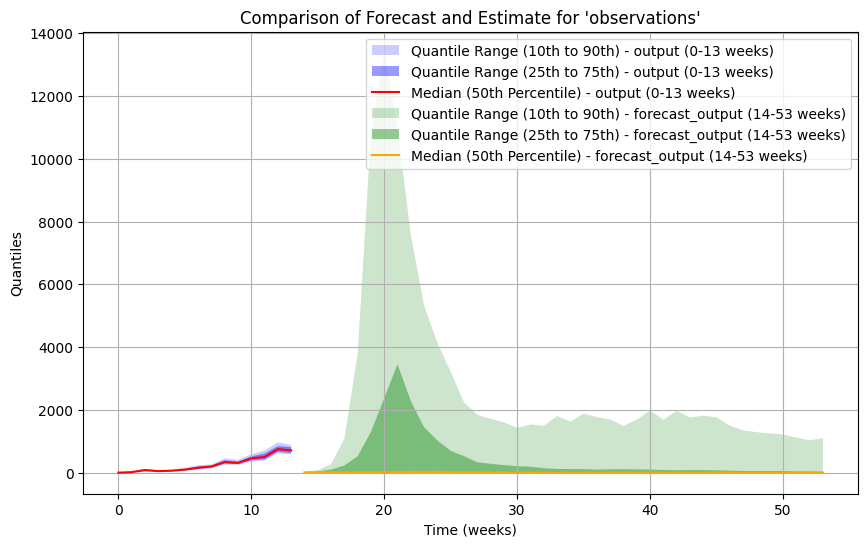

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

key = "observations"
node_index = 0
truth = None

# Get the quantiles for the two datasets
key_quantiles_1 = np.array(output.model_data_quantiles)  # Weeks 0 to 13 (output)
key_quantiles_2 = np.array(
    forecast_output_2.model_data_quantiles
)  # Weeks 14 to 53 (forecast_output)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot first dataset (output) for the first 14 weeks (0 to 13)
plt.fill_between(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 3, 0],  # 10th Percentile
    key_quantiles_1[:, 22 - 3, 0],  # 90th Percentile
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th) - output (0-13 weeks)",
)

plt.fill_between(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 6, 0],  # 25th Percentile
    key_quantiles_1[:, 22 - 6, 0],  # 75th Percentile
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th) - output (0-13 weeks)",
)

plt.plot(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 11, 0],  # Median (50th Percentile)
    color="red",
    label="Median (50th Percentile) - output (0-13 weeks)",
)

# Plot second dataset (forecast_output) for the next 40 weeks (14 to 53)
plt.fill_between(
    np.arange(14, 54),  # Weeks 14-53
    key_quantiles_2[:, 3, 0],  # 10th Percentile
    key_quantiles_2[:, 22 - 3, 0],  # 90th Percentile
    facecolor="green",
    alpha=0.2,
    label="Quantile Range (10th to 90th) - forecast_output (14-53 weeks)",
)

plt.fill_between(
    np.arange(14, 54),  # Weeks 14-53
    key_quantiles_2[:, 6, 0],  # 25th Percentile
    key_quantiles_2[:, 22 - 6, 0],  # 75th Percentile
    facecolor="green",
    alpha=0.4,
    label="Quantile Range (25th to 75th) - forecast_output (14-53 weeks)",
)

plt.plot(
    np.arange(14, 54),  # Weeks 14-53
    key_quantiles_2[:, 11, 0],  # Median (50th Percentile)
    color="orange",
    label="Median (50th Percentile) - forecast_output (14-53 weeks)",
)

# Title, labels, and legend
plt.title(f"Comparison of Forecast and Estimate for '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)

# Show the combined plot
plt.show()


In [ ]:
# sim = ForecastSimulation(
#     initial_particles=output.particles,
#     rume=rume,
#     params_space=params_space,
#     model_link=observations.model_link,
#     duration=40,
#     request_data={
#         model_data: model_link,
#         particle_cloud: [dates],
#         param_quantiles: [dates],
#     },
# )

In [ ]:
output.model_data